In [1]:
import sys
from os import getcwd
from os.path import dirname

path = dirname(dirname(getcwd()))
sys.path.append(path)

from MintPy.interpret_toolkit import InterpretToolkit
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import pickle
import joblib

In [2]:
# Define target feature
TARGET_COLUMN = 'cat_rt'

# read in the model and data for this tutorial
rf = joblib.load('RandomForest.pkl')
data  = pd.read_csv('example_data.csv')

# get actual target data
targets = data[TARGET_COLUMN].values

# only want to use these columns below
cols_to_use = ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'high_cloud',
            'lat_hf', 'low_cloud', 'mid_cloud', 'sat_irbt', 'sens_hf',
            'sfcT_hrs_ab_frez', 'sfcT_hrs_bl_frez', 'sfc_rough', 'sfc_temp',
            'swave_flux','temp2m', 'tmp2m_hrs_ab_frez', 'tmp2m_hrs_bl_frez',
            'tot_cloud', 'uplwav_flux','vbd_flux', 'vdd_flux','wind10m',
            'date_marker', 'urban','rural','d_ground','d_rad_d','d_rad_u',
            'hrrr_dT']

# get predictor subset of dataframe (only the predictors used in training the model)
data = data[cols_to_use]

lr = LogisticRegression(C=1)
lr.fit(data, targets)


/Users/Home/.conda/envs/deep/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Home/.conda/envs/deep/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Initializing InterpretToolkit

To initialize `InterpretToolkit`, you need a model object (e.g., a trained sci-kit learn model object) or a list of model objects and a `pandas.Dataframe` of the training examples and targets. 
If it is the case that `examples` and `targets` are arrays, then you must provide the feature names so that the data can be converted to a `pandas.DataFrame`. Now we can explore the various functions and plotting availabe in `InterpretToolkit`. 

In [3]:
myInterpreter = InterpretToolkit(model=[rf, lr], 
                             examples=data, 
                             targets=targets, 
                             classification=True)

# Permutation Importance

The permutation importance calculations are performed by a stripped-down version of PermutationImportance (see https://permutationimportance.readthedocs.io/en/latest/ for additional details). In this example, we want the top 5 predictors as determined by the multipass permutation importance method (SOURCE). Additionally, we are using the Area under the Curve (AUC) as our error metric. 

Additional options include 
* Performing bootstraping for confidence interval on predictor ranking (`nbootstrap`)
* Using multiple processors for parallelization (`njobs`)


In [4]:
#returns a dictionary of top 5 predictors
results = myInterpreter.permutation_importance(
                                               n_vars=5, 
                                               evaluation_fn='auc', 
                                               nbootstrap=1, 
                                               subsample = 1.0,
                                               njobs=3
                                              )

# Need to write a get functions to simplify this extraction process!!!

important_vars = list(results['RandomForestClassifier'].retrieve_multipass().keys())
print(results['RandomForestClassifier'].retrieve_multipass())

# Show that there is a built-in function to save the results of the permutation importance!!!

Processing RandomForestClassifier...
Using 3 of processors to compute importance...
Starting on the important variable 1 out of 5...
Starting on the important variable 2 out of 5...
Starting on the important variable 3 out of 5...
Starting on the important variable 4 out of 5...
Starting on the important variable 5 out of 5...
Processing LogisticRegression...
Using 3 of processors to compute importance...
Starting on the important variable 1 out of 5...
Starting on the important variable 2 out of 5...
Starting on the important variable 3 out of 5...
Starting on the important variable 4 out of 5...
Starting on the important variable 5 out of 5...
{'dllwave_flux': (0, array([1.])), 'dwpt2m': (1, array([1.])), 'fric_vel': (2, array([1.])), 'gflux': (3, array([1.])), 'high_cloud': (4, array([1.]))}


0.2


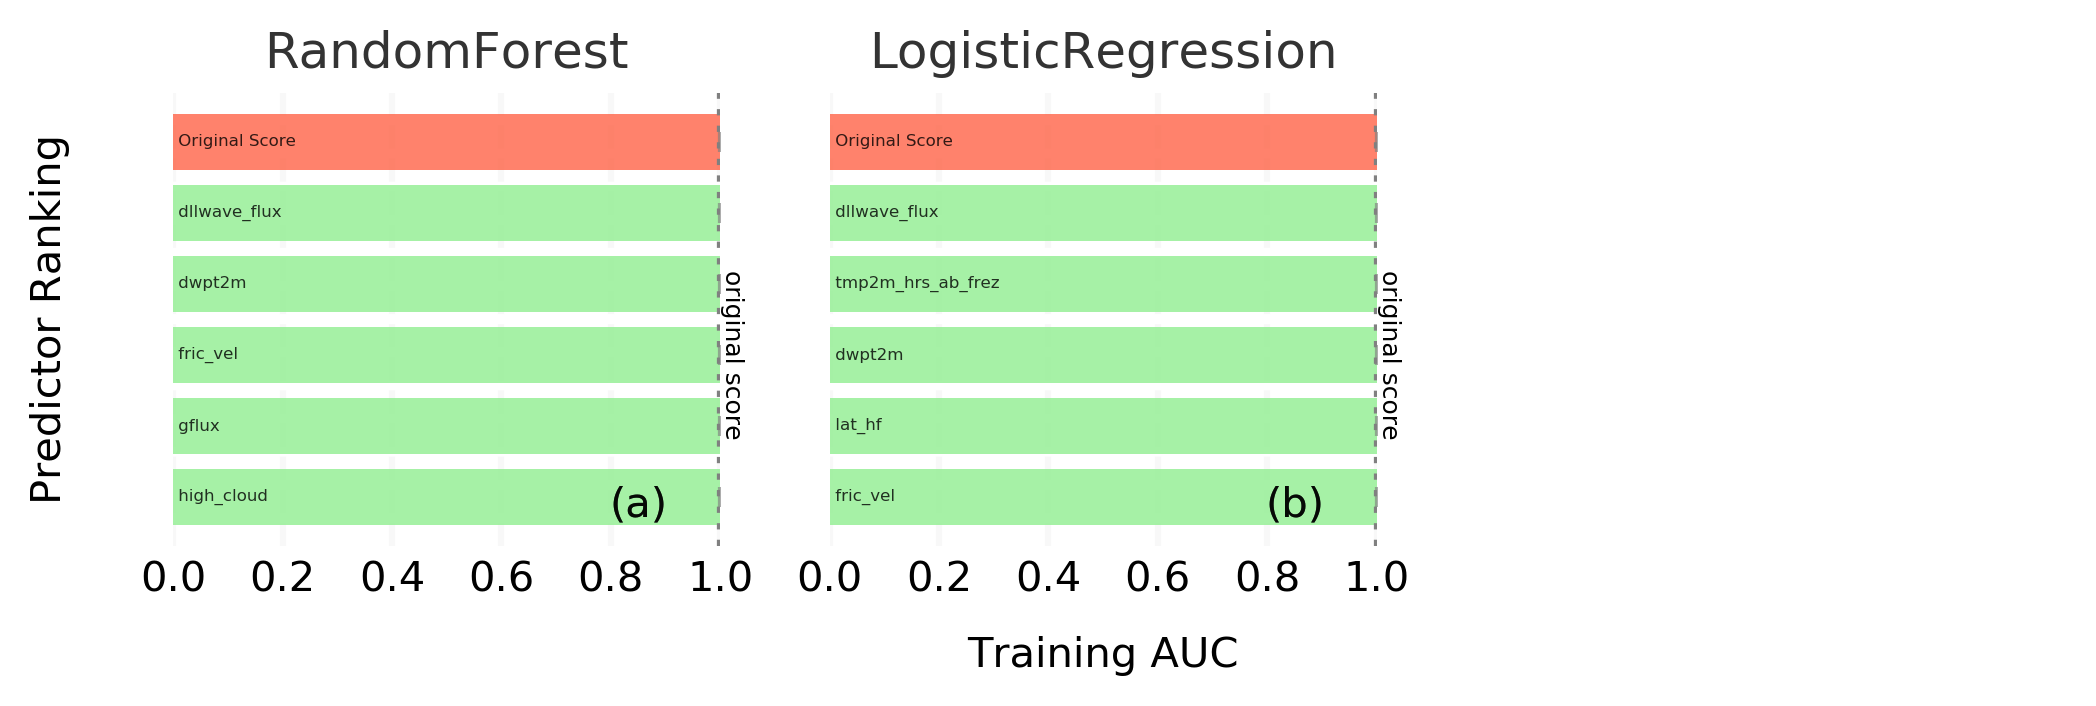

In [5]:
myInterpreter.plot_importance(multipass=True, 
                              metric = "Training AUC",
                              num_vars_to_plot=10)

# Fix the axis labelling for cases with only one panel!!!

# Partial Dependence Plots

Using 3 processors...
0.6


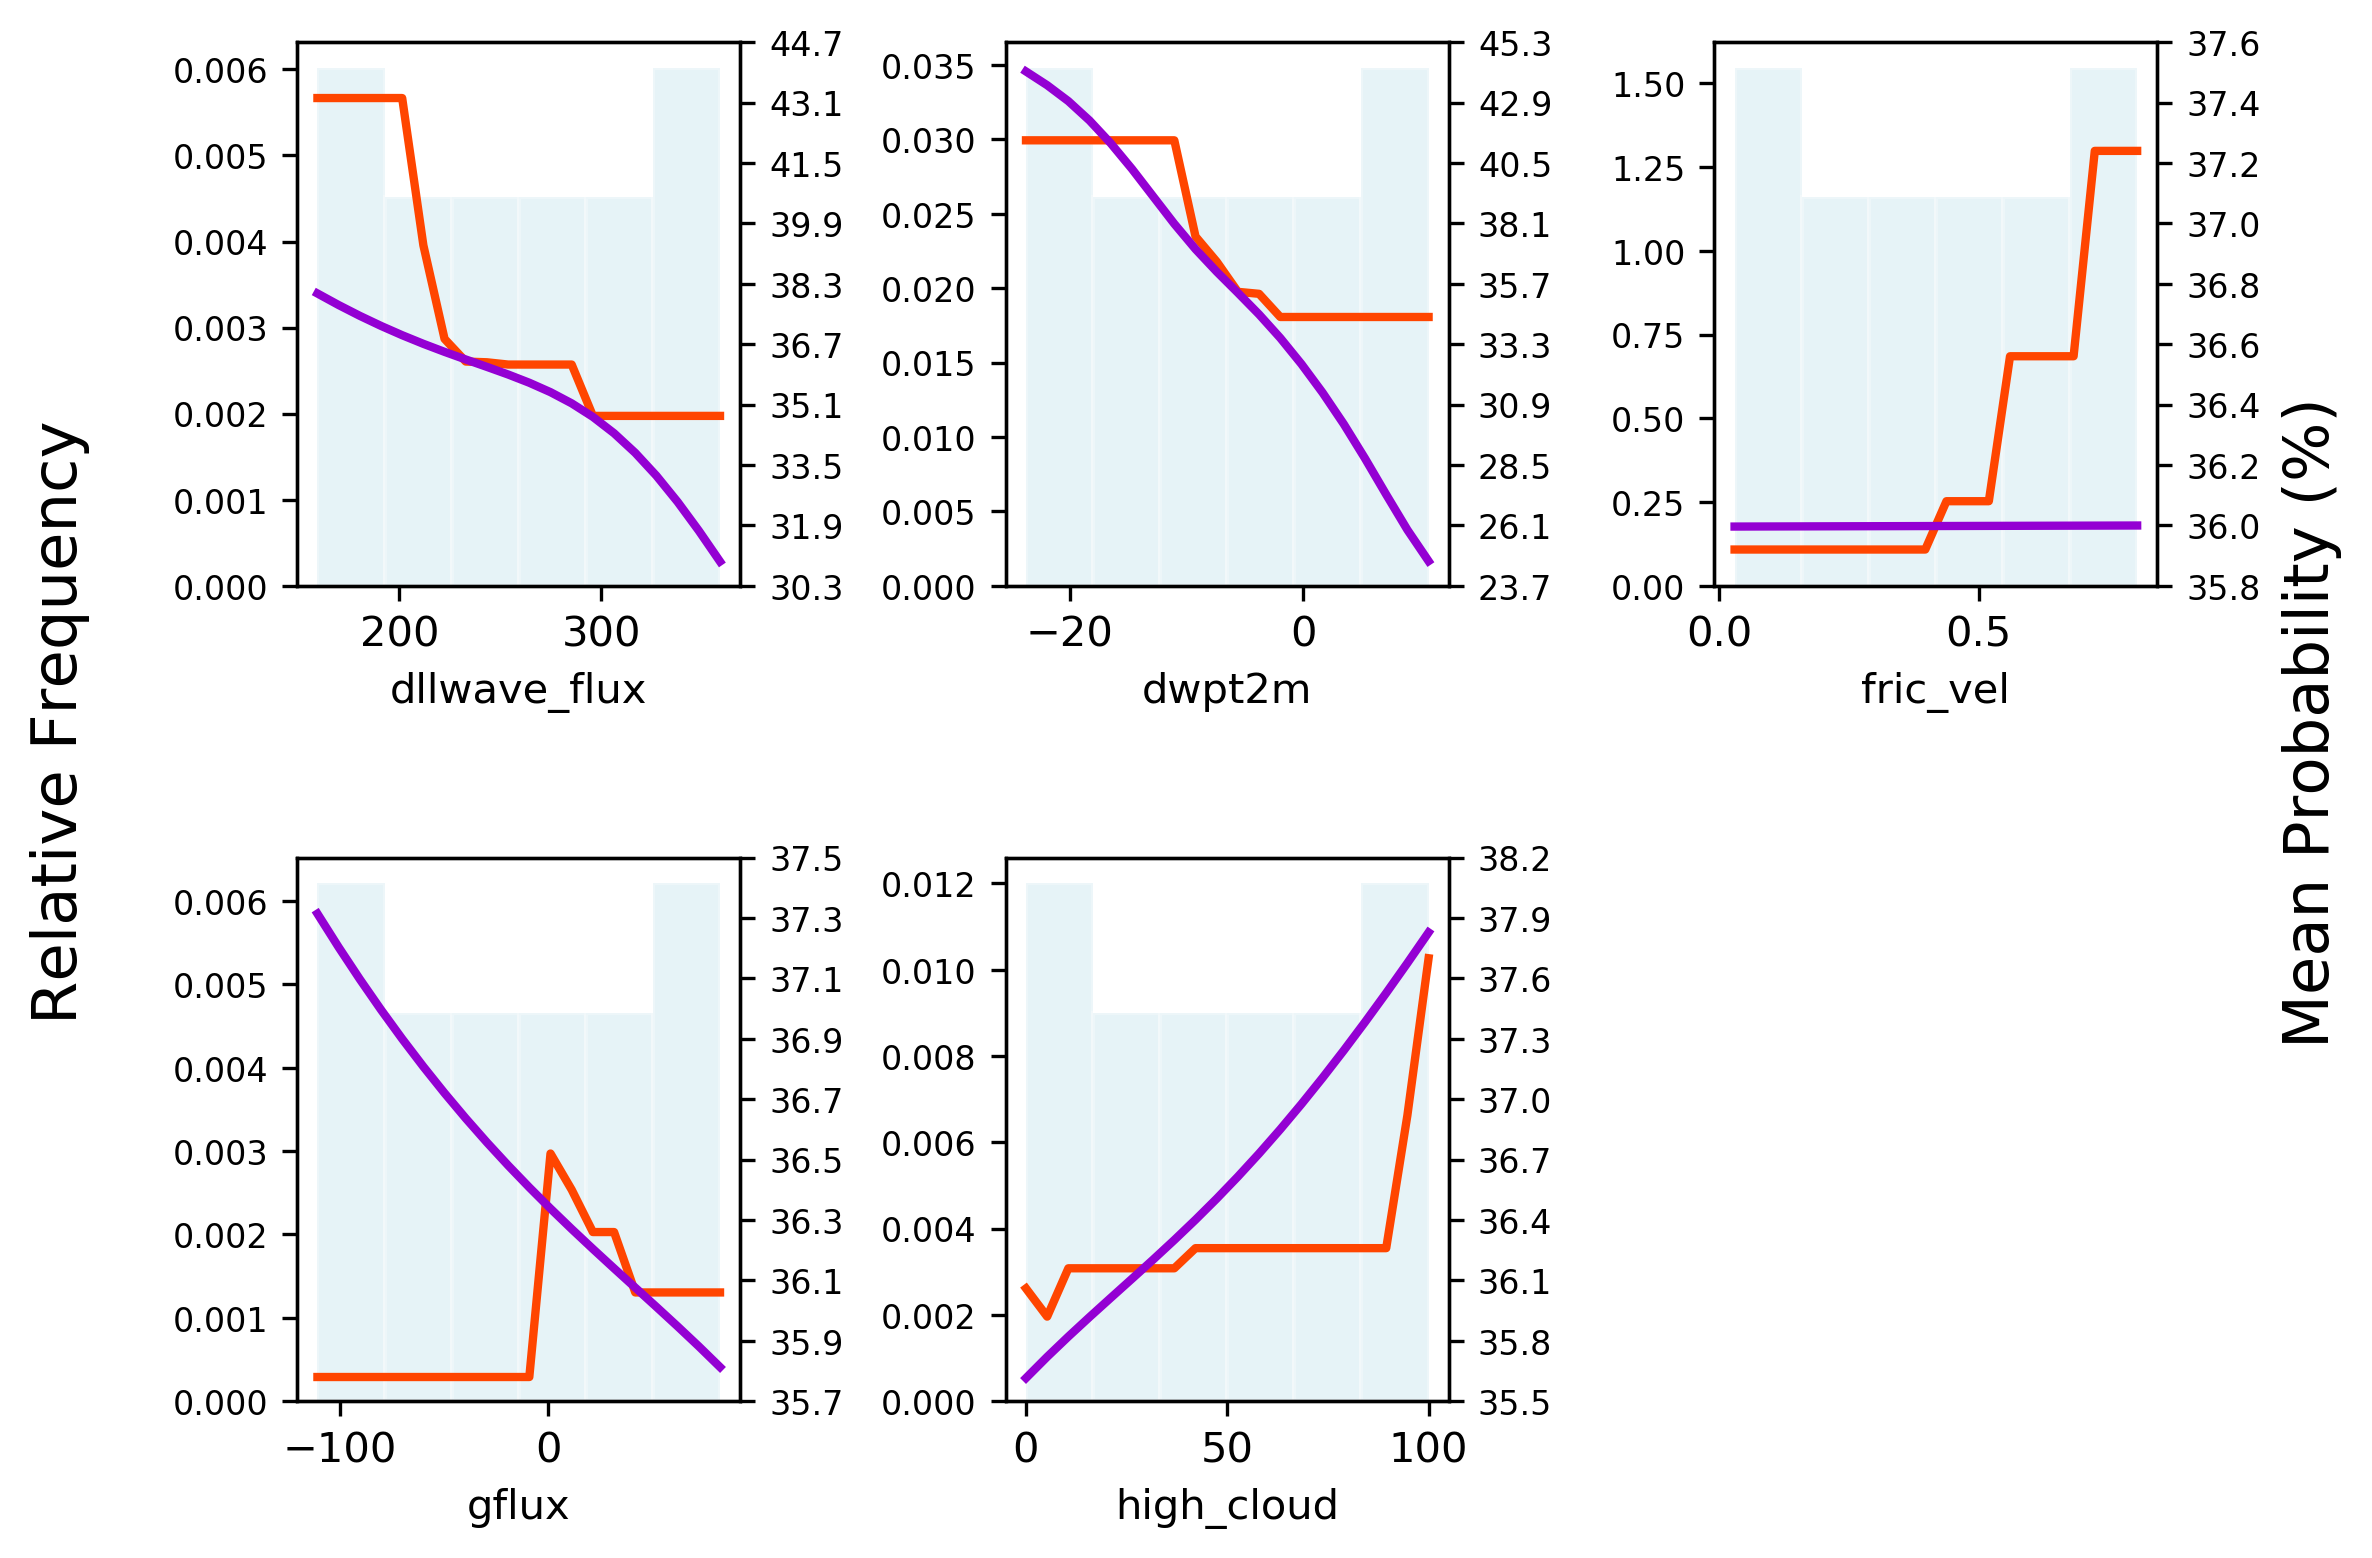

In [6]:
myInterpreter.run_pd(features=important_vars, nbootstrap=1, subsample=1.0, njobs=3)
fig, axes = myInterpreter.plot_pd()

# Add a functionality for units to be included in the x-axis labelling 
# Add some functionality to generate automatically generate user-friendly right y ticks marks
# Add ability to unnormalize data for the background histogram 

# Accumulated Local Effect

Models for ALE: ['RandomForestClassifier', 'LogisticRegression']
Using 3 processors...
0.6


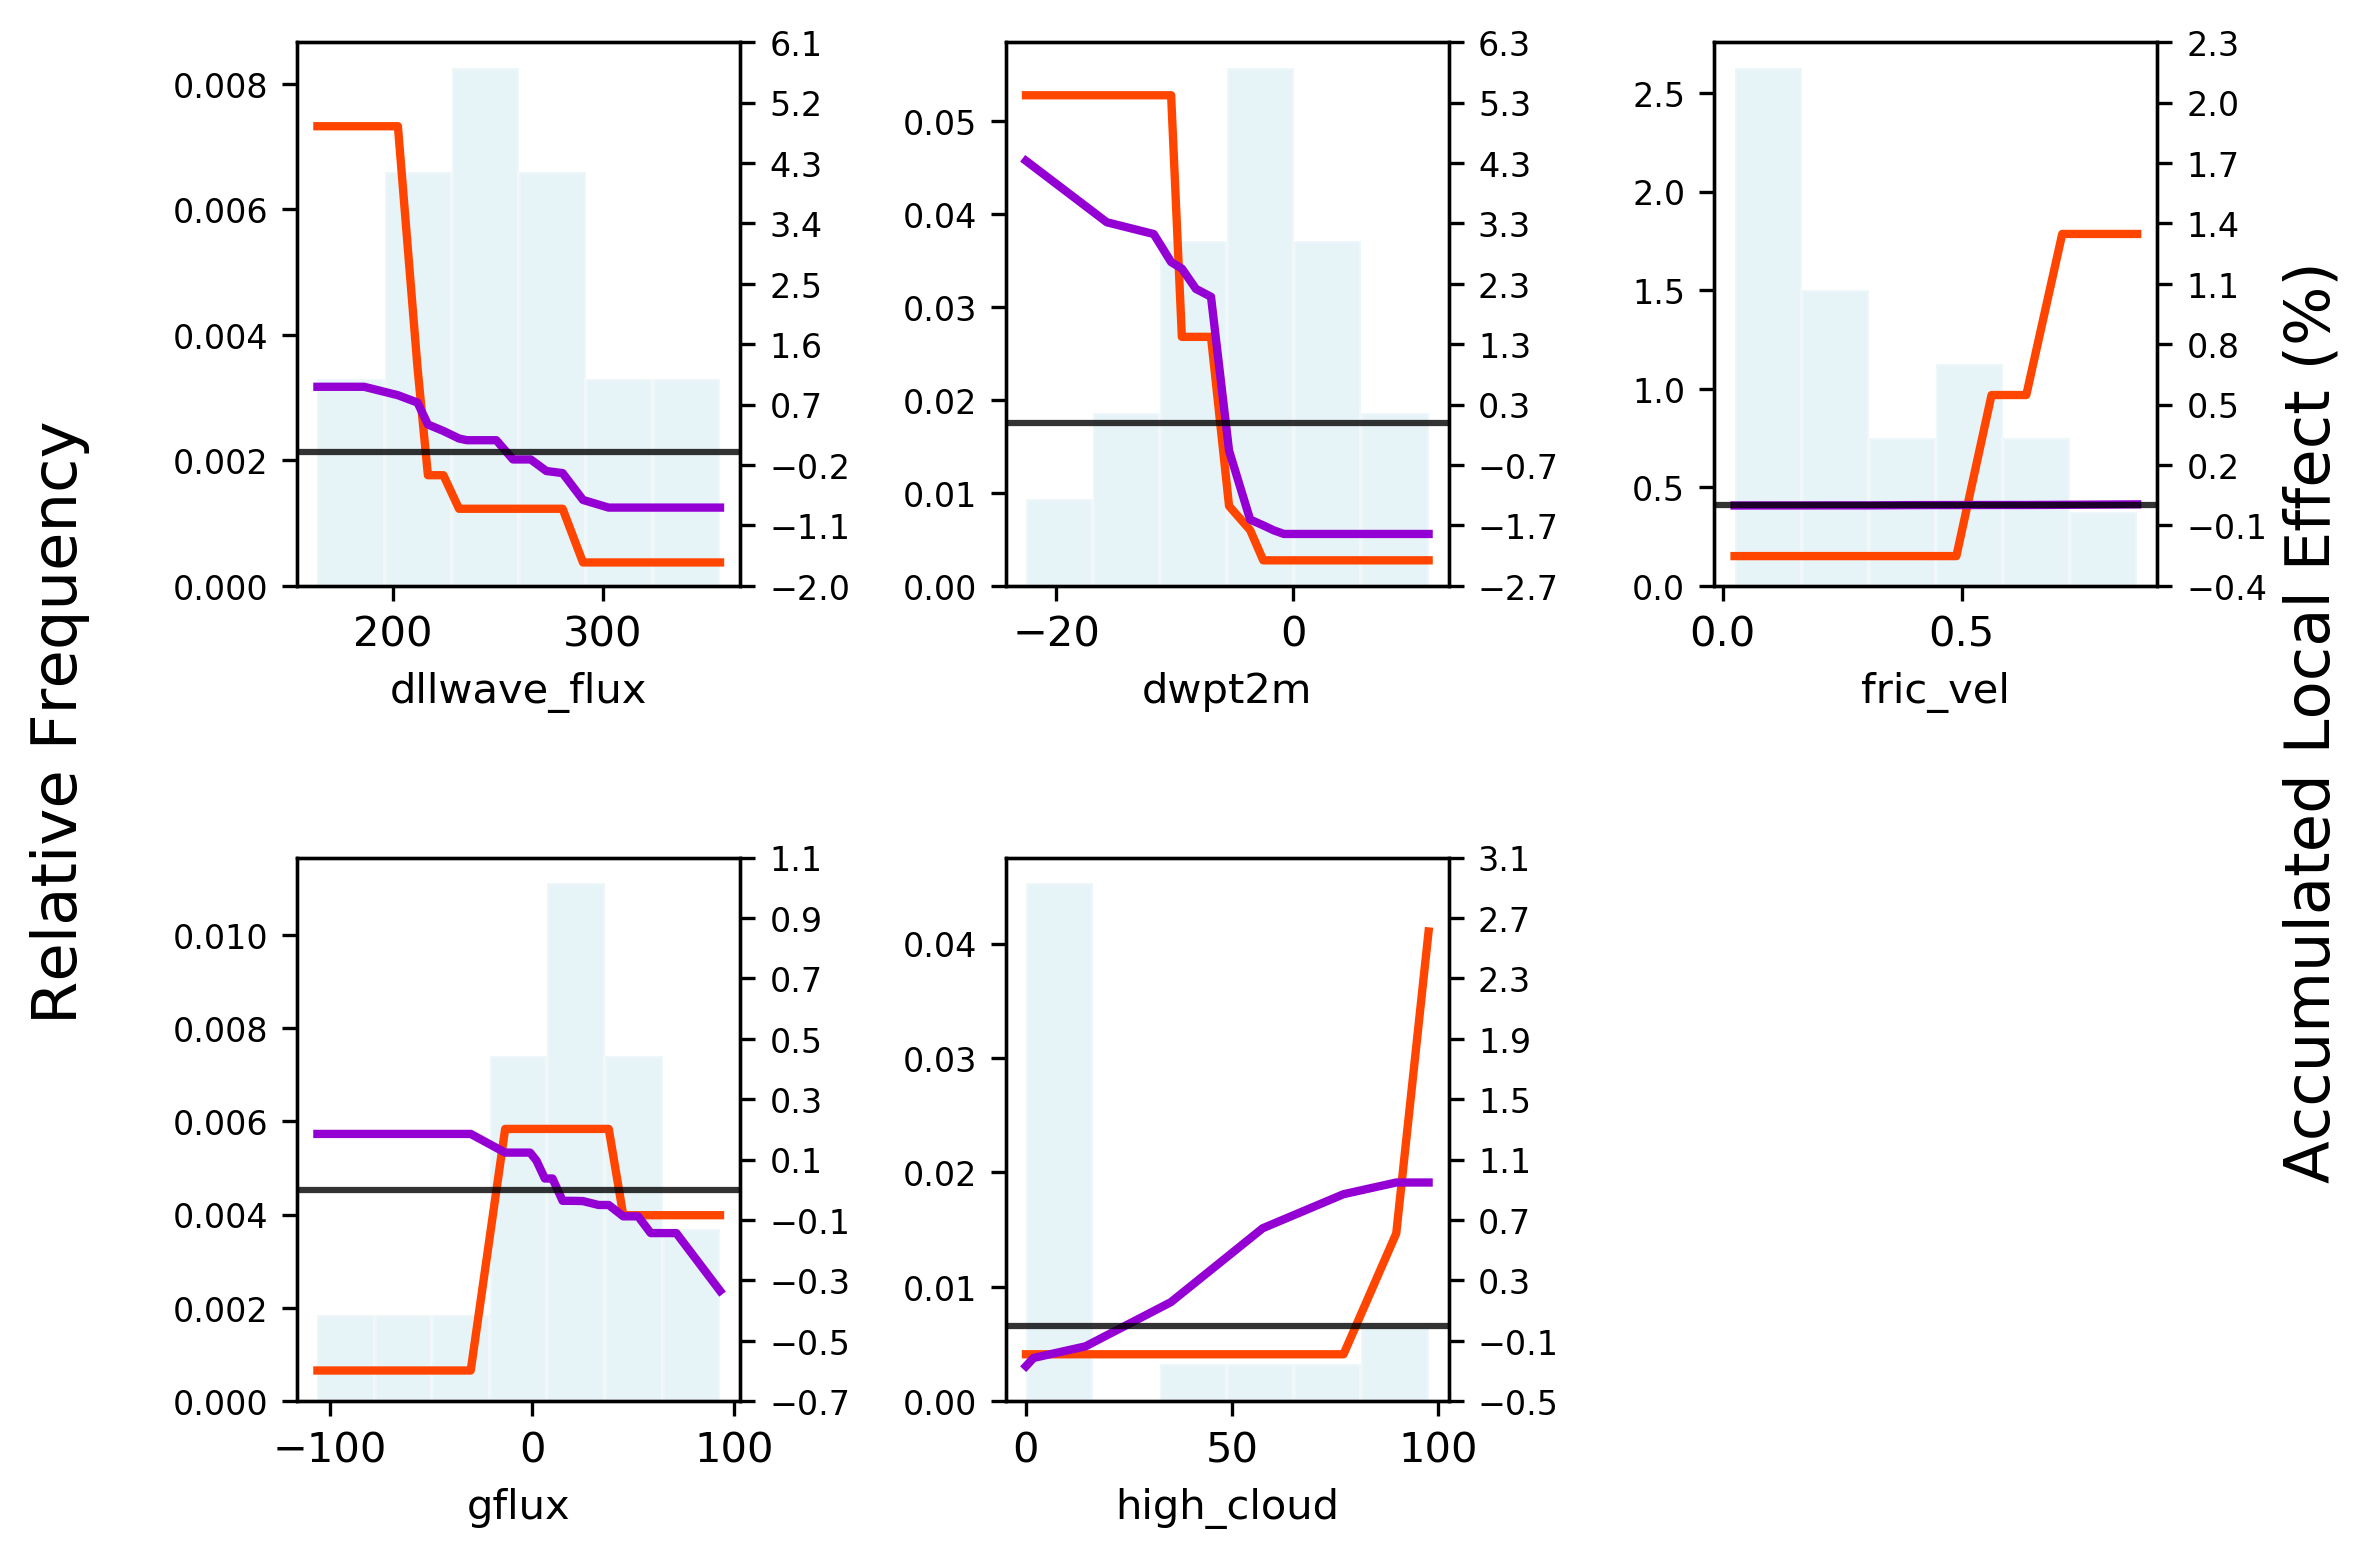

In [7]:
myInterpreter.run_ale(features=important_vars, nbootstrap=1, subsample=1.0, njobs=3)
fig, axes = myInterpreter.plot_ale()

# Feature Contributions (Random Forest Only)

For random forest, it is possible to breakdown a prediction into a series of contributions from the predictors. 

In [8]:
out_dict = myInterpreter.run_tree_interpreter(performance_based=True, n_examples=100)

Processing hits...
Interpreting 36 examples...
Processing misses...
Interpreting 36 examples...
Processing false_alarms...
Interpreting 64 examples...
Processing corr_negs...
Interpreting 64 examples...
LogisticRegression is not accepted for this method. Passing...


1.0
hits
misses
false_alarms
corr_negs


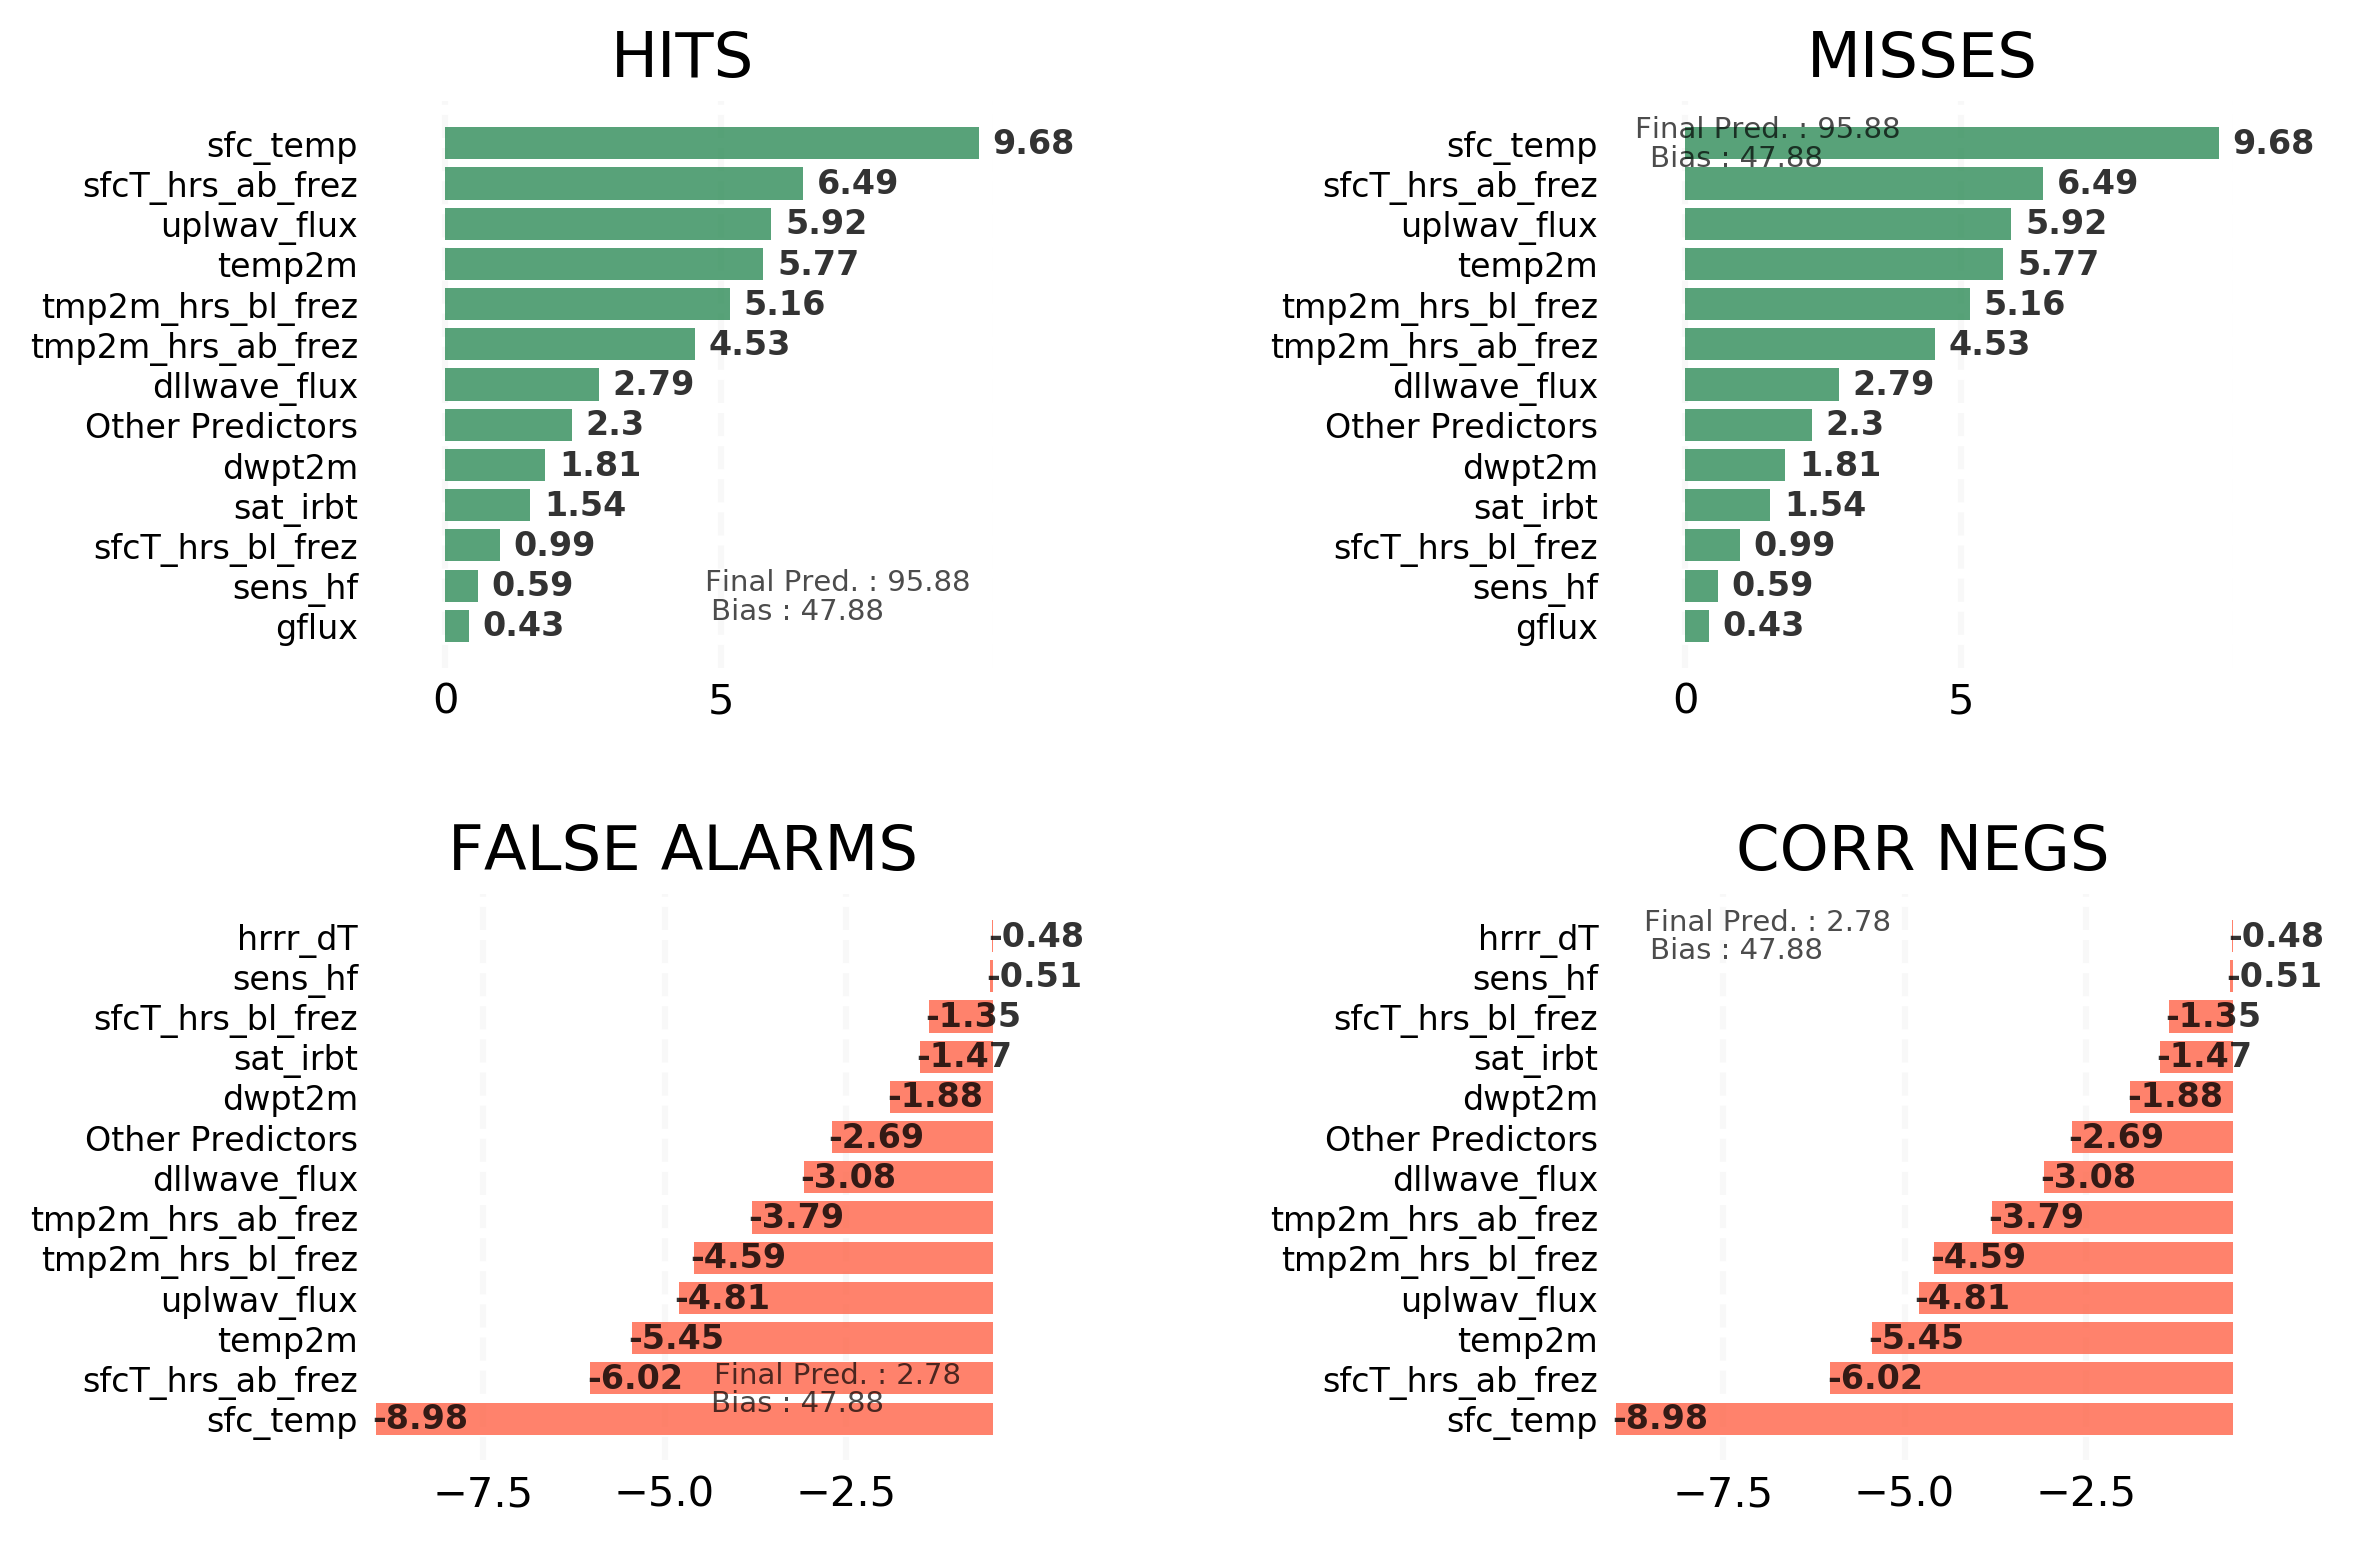

In [9]:
fig = myInterpreter.plot_tree_interpreter()

# Fix the positioning of the Final Pred. and Bias!!!
# Fix the position of the end-bar numbers (especially for negative numbers)

In [10]:
# Second-order PDP and ALE 

# Saving the figures
c_plot.save_figure(fig, fname, bbox_inches="tight", dpi=300, aformat="png")